Uniform[-√3,√3]: k* = 27, Q*(k*) = 0.947
Normal N(0,1): k* = 22, Q*(k*) = 0.950
ShiftedExp(lambda=1,c=-1): k* = 18, Q*(k*) = 0.939


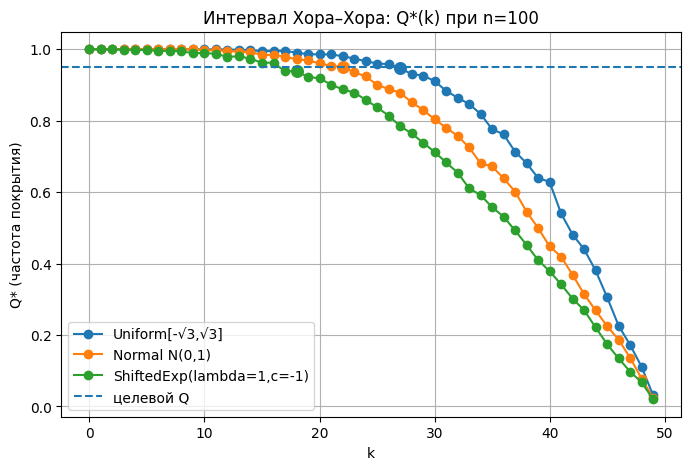

Оптимальные k* для каждого распределения:
                distribution  k*    Q*(k*)
0            Uniform[-√3,√3]  27  0.947333
1              Normal N(0,1)  22  0.950333
2  ShiftedExp(lambda=1,c=-1)  18  0.938667

Доверительные интервалы для квантилей (1%, 50%, 99%)
                 distribution     p     method         L         U     width
0             Uniform[-√3,√3]  0.01  jackknife -1.712889 -1.678397  0.034492
1             Uniform[-√3,√3]  0.01  bootstrap -1.704719 -1.545284  0.159435
2             Uniform[-√3,√3]  0.50  jackknife -0.652595  0.335901  0.988495
3             Uniform[-√3,√3]  0.50  bootstrap -0.554962  0.249131  0.804093
4             Uniform[-√3,√3]  0.99  jackknife  1.672350  1.713217  0.040867
5             Uniform[-√3,√3]  0.99  bootstrap  1.592632  1.718891  0.126259
6               Normal N(0,1)  0.01  jackknife -2.854052 -2.082327  0.771725
7               Normal N(0,1)  0.01  bootstrap -2.647200 -1.743603  0.903597
8               Normal N(0,1)  0.50  ja

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

Q = 0.95
alpha = 1 - Q
n = 100
N_trials = 3000
rng = np.random.default_rng(42)

def gen_uniform(n):
    a, b = -math.sqrt(3), math.sqrt(3)
    return rng.uniform(a, b, size=n), 0.0, (a, b)

def gen_normal(n):
    return rng.normal(0, 1, size=n), 0.0, None

def gen_shifted_exp(n):
    lam, c = 1.0, -1.0
    return rng.exponential(scale=1/lam, size=n) + c, 0.0, (c, None)

distributions = {
    "Uniform[-√3,√3]": gen_uniform,
    "Normal N(0,1)": gen_normal,
    "ShiftedExp(lambda=1,c=-1)": gen_shifted_exp,
}

def ci_hora_hora_k(x, alpha, k):
    n = len(x)
    xs = np.sort(x)
    a = float(xs[k])
    b = float(xs[n - k - 1])
    m = float(np.mean(x))
    inner = math.log(2/alpha)/(2*n) - 1/(6*n)
    eps = (b - a) * math.sqrt(max(0.0, inner))
    return m - eps, m + eps

def choose_k_star(qstars, Q):
    qstars = np.asarray(qstars)
    idx = int(np.argmin(np.abs(qstars - Q)))
    return idx, float(qstars[idx])

rows = []
kmax = (n - 1) // 2
k_star_info = []

plt.figure(figsize=(8, 5))

for dist_name, gen in distributions.items():
    qstars = []
    for k in range(kmax + 1):
        covered = 0
        for _ in range(N_trials):
            x, mu_true, _ = gen(n)
            L, U = ci_hora_hora_k(x, alpha, k)
            if L <= mu_true <= U:
                covered += 1
        qstar = covered / N_trials
        rows.append({"distribution": dist_name, "n": n, "k": k, "Q*": qstar})
        qstars.append(qstar)

    k_star, q_star = choose_k_star(qstars, Q)
    k_star_info.append({"distribution": dist_name, "k*": k_star, "Q*(k*)": q_star})
    print(f"{dist_name}: k* = {k_star}, Q*(k*) = {q_star:.3f}")

    ks = range(kmax + 1)
    plt.plot(ks, qstars, marker="o", label=dist_name)
    plt.scatter([k_star], [q_star], s=70)

plt.axhline(Q, linestyle="--", label="целевой Q")
plt.xlabel("k")
plt.ylabel("Q* (частота покрытия)")
plt.title(f"Интервал Хора–Хора: Q*(k) при n={n}")
plt.grid(True)
plt.legend()
plt.show()

df_hora = pd.DataFrame(rows)
df_kstar = pd.DataFrame(k_star_info)
print("Оптимальные k* для каждого распределения:")
print(df_kstar)

def stat_quantile(p):
    def f(x):
        return float(np.quantile(x, p))
    return f

def jackknife_ci(x, stat_func, alpha):
    x = np.asarray(x)
    n = len(x)
    theta_full = stat_func(x)
    jack_vals = np.empty(n)

    for i in range(n):
        jack_vals[i] = stat_func(np.delete(x, i))

    theta_bar = np.mean(jack_vals)
    var_jack = (n - 1) / n * np.sum((jack_vals - theta_bar) ** 2)
    se_jack = math.sqrt(var_jack)

    t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)
    L = theta_full - t_crit * se_jack
    U = theta_full + t_crit * se_jack
    return L, U

def bootstrap_ci(x, stat_func, alpha, B=2000):
    x = np.asarray(x)
    n = len(x)
    idx = rng.integers(0, n, size=(B, n))
    thetas = np.array([stat_func(x[i]) for i in idx])

    lower = np.quantile(thetas, alpha / 2)
    upper = np.quantile(thetas, 1 - alpha / 2)
    return float(lower), float(upper)

p_list = [0.01, 0.5, 0.99]
rows_q = []

for dist_name, gen in distributions.items():
    x, _, _ = gen(n)
    for p in p_list:
        f = stat_quantile(p)
        L_j, U_j = jackknife_ci(x, f, alpha)
        L_b, U_b = bootstrap_ci(x, f, alpha, B=3000)

        rows_q.append({
            "distribution": dist_name,
            "p": p,
            "method": "jackknife",
            "L": L_j,
            "U": U_j,
            "width": U_j - L_j,
        })
        rows_q.append({
            "distribution": dist_name,
            "p": p,
            "method": "bootstrap",
            "L": L_b,
            "U": U_b,
            "width": U_b - L_b,
        })

df_q = pd.DataFrame(rows_q)
print("\nДоверительные интервалы для квантилей (1%, 50%, 99%)")
print(df_q)

Домашнее задание

Delta, eps_theory, eps_true, width_theory, width_true
0.5 0.06476443971019707 0.02798090233784598 0.12952887942039415 0.05596180467569196
1.0 0.12952887942039415 0.057624204806874475 0.2590577588407883 0.11524840961374895
1.5 0.19429331913059122 0.0863382093261863 0.38858663826118245 0.1726764186523726


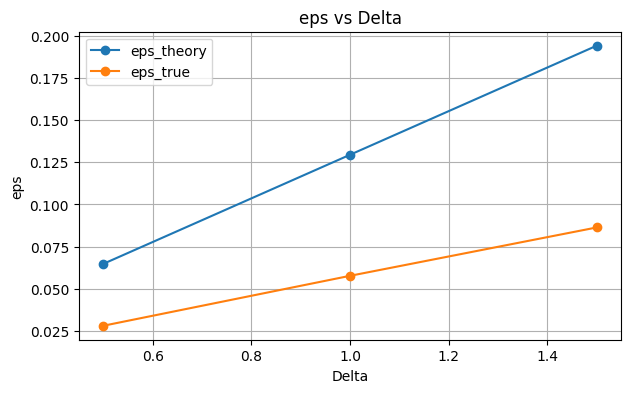

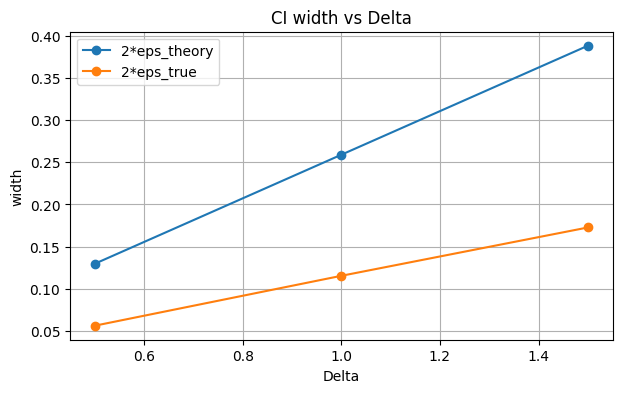

In [4]:
Delta_list = [0.5, 1.0, 1.5]
N_trials_delta = 3000

def theoretic_eps(Delta, n, alpha):
    inner = math.log(2 / alpha) / (2 * n) - 1 / (6 * n)
    inner = max(inner, 0.0)
    return Delta * math.sqrt(inner)

def gen_uniform_width(n, Delta):
    a = -Delta / 2.0
    b =  Delta / 2.0
    return rng.uniform(a, b, size=n), 0.0

eps_theory_list = [theoretic_eps(Delta, n, alpha) for Delta in Delta_list]
width_theory_list = [2.0 * e for e in eps_theory_list]

eps_true_list = []
width_true_list = []

for Delta in Delta_list:
    errs = []
    for _ in range(N_trials_delta):
        x, mu = gen_uniform_width(n, Delta)
        errs.append(abs(float(np.mean(x)) - mu))
    eps_true = float(np.quantile(errs, Q))
    eps_true_list.append(eps_true)
    width_true_list.append(2.0 * eps_true)

print("Delta, eps_theory, eps_true, width_theory, width_true")
for Delta, et, er, wt, wr in zip(Delta_list, eps_theory_list, eps_true_list, width_theory_list, width_true_list):
    print(Delta, et, er, wt, wr)

plt.figure(figsize=(7, 4))
plt.plot(Delta_list, eps_theory_list, marker="o", label="eps_theory")
plt.plot(Delta_list, eps_true_list, marker="o", label="eps_true")
plt.xlabel("Delta")
plt.ylabel("eps")
plt.title("eps vs Delta")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(Delta_list, width_theory_list, marker="o", label="2*eps_theory")
plt.plot(Delta_list, width_true_list, marker="o", label="2*eps_true")
plt.xlabel("Delta")
plt.ylabel("width")
plt.title("CI width vs Delta")
plt.grid(True)
plt.legend()
plt.show()

Вывод: при увеличении delta погрешность растёт, а теоретический интервал получается заметно шире, чем реально нужно.